In [1]:
from torch.utils.data import Dataset, Subset
import torchvision.transforms as transforms
import config
import csv
from torch.utils.data import random_split
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from tqdm.auto import tqdm

In [2]:
class JetbotDataset(Dataset):
    def __init__(self, csv_path, data_dir, image_size, num_prev_frames, transform=None, seed=42): # Renamed args
        """
        Loads combined Jetbot data and prepares sequences.
        Train/test splitting should be done externally.

        Args:
            csv_path: Path to the combined CSV file (e.g., 'jetbot_data/data.csv').
            data_dir: Path to the base directory containing the combined 'images' folder
                      (e.g., 'jetbot_data').
            image_size: Target image size.
            num_prev_frames: Number of previous frames for history.
            transform: PyTorch transforms to apply to images.
            seed: Random seed for reproducible train/test splits if done externally.
        """
        super().__init__()
        self.csv_path = csv_path
        self.data_dir = data_dir # Base directory for combined data
        self.image_size = image_size
        self.transform = transform
        self.num_prev_frames = num_prev_frames
        self.seed = seed

        self.dataframe = self.load_data()
        # Calculate indices in the dataframe that are valid STARTING points for a sequence
        self.valid_indices = self._calculate_valid_indices()

    def load_data(self):
        """Loads the combined dataframe."""
        if not os.path.exists(self.csv_path):
            raise FileNotFoundError(f"Combined CSV file not found: {self.csv_path}")
        df = pd.read_csv(self.csv_path)
        print(f"Loaded combined CSV with columns: {df.columns.tolist()}")
        if 'session_id' not in df.columns:
             raise ValueError("'session_id' column not found in CSV. Please run combine_data.py again.")
        return df

    def _calculate_valid_indices(self):
        """
        Valid START indices i such that
           • i, i-stride, i-2*stride, … are in the same session
           • stride == config.FRAME_STRIDE  (e.g. 6 for 5 Hz)
        """
        stride = config.FRAME_STRIDE
        valid = []
        for i in range(self.num_prev_frames * stride, len(self.dataframe)):
            if i % stride:                # keep only every Nth frame
                continue
            sess_now = self.dataframe.iloc[i]['session_id']
            sess_hist = self.dataframe.iloc[i - self.num_prev_frames*stride]['session_id']
            if sess_now == sess_hist:
                valid.append(i)
        return valid

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        stride      = config.FRAME_STRIDE
        actual_idx  = self.valid_indices[idx]

        cur_row     = self.dataframe.iloc[actual_idx]
        cur_img     = Image.open(os.path.join(self.data_dir, cur_row['image_path'])).convert("RGB")
        action      = cur_row['action']

        prev_frames = []
        for n in range(self.num_prev_frames, 0, -1):
            prev_row = self.dataframe.iloc[actual_idx - n*stride]
            prev_img = Image.open(os.path.join(self.data_dir, prev_row['image_path'])).convert("RGB")
            prev_frames.append(self.transform(prev_img) if self.transform else prev_img)

        cur_img = self.transform(cur_img) if self.transform else cur_img
        prev_frames_tensor = torch.cat(prev_frames, dim=0)

        return cur_img, torch.tensor([action], dtype=torch.float32), prev_frames_tensor

def save_existing_split(train_dataset, test_dataset, filename="dataset_split.pth"):
    """Saves the indices of existing Subset objects to a file.

    Args:
        train_dataset: The Subset object representing the training set.
        test_dataset: The Subset object representing the test set.
        filename: The name of the file to save the indices to.
    """

    # Check if they are actually Subset objects.  Important!
    if not isinstance(train_dataset, Subset) or not isinstance(test_dataset, Subset):
        raise TypeError("Both train_dataset and test_dataset must be Subset objects.")

    # Extract the indices. This is the key step.
    train_indices = train_dataset.indices
    test_indices = test_dataset.indices

    # Combine them into a single list (or tuple) for saving.
    all_indices = [train_indices, test_indices]

    # Save the indices using torch.save
    torch.save(all_indices, os.path.join(config.OUTPUT_DIR, filename))

def load_train_test_split(dataset, filename="dataset_split.pth"):
    """Loads the indices of existing Subset objects from a file."""

    filepath = os.path.join(config.OUTPUT_DIR, filename)
    if not os.path.exists(filepath):
        return None, None # Return None if file does not exist

    splits = torch.load(filepath)
    return tuple(Subset(dataset, indices) for indices in splits)

def display_dataset_entry(dataset_entry):
    frame, action, previous_frames = dataset_entry
    
    # Calculate the total number of frames to display
    total_frames = config.NUM_PREV_FRAMES + 1  # Previous frames + current frame
    
    # Create a figure with horizontal subplots
    plt.figure(figsize=(5*total_frames, 5))
    
    # Print the action
    plt.suptitle(f'Action: {action}', fontsize=16)
    
    # Display previous frames
    for i in range(config.NUM_PREV_FRAMES):
        plt.subplot(1, total_frames, i+1)
        prev_frame = previous_frames[(i * 3):(i + 1) * 3, :, :]  # Extract each frame (C, H, W)
        display_frame(prev_frame, title=f'Previous Frame {i+1}')
    
    # Display current frame
    plt.subplot(1, total_frames, total_frames)
    display_frame(frame, title='Current Frame')
    
    plt.tight_layout()
    plt.show()

def display_frame(frame, title=None):
    # Unnormalize the frame
    frame = (frame.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]
    frame = (frame * 255).type(torch.uint8)  # Convert to uint8
    
    # Convert to PIL Image and then to numpy for matplotlib
    pil_frame = transforms.ToPILImage()(frame)
    
    # Display the frame
    plt.imshow(pil_frame)
    plt.axis('off')
    
    if title:
        plt.title(title)


def get_action_percentages():
    try:
        # Construct the full path using the config variable
        full_csv_path = config.CSV_PATH
    
        print(f"Loading combined dataset from: {full_csv_path}")
        df = pd.read_csv(full_csv_path)
    
        # --- Calculate Value Counts ---
        action_counts = df['action'].value_counts()
    
        # --- Calculate Percentages ---
        action_percentages = df['action'].value_counts(normalize=True) * 100
    
        # --- Print Results ---
        print("\n--- Action Split in Combined Dataset ---")
        print("Action Value Counts:")
        print(action_counts)
        print("\nAction Percentages:")
        print(action_percentages.map('{:.2f}%'.format)) # Format as percentage
        print("----------------------------------------")
    
    except FileNotFoundError:
        print(f"Error: Combined CSV file not found at expected location: {full_csv_path}")
        print("Please ensure combine_data.py has run successfully and config.py points to the correct file.")
    except KeyError:
        print("Error: 'action' column not found in the CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")    

def split_train_test_by_session_id(dataset, train_split=0.8, seed=42):
    """
    Splits a dataset (expected to have a .dataframe attribute with 'session_id')
    into training and testing Subsets based on session IDs.

    Args:
        dataset (torch.utils.data.Dataset): An instance of a dataset class
            that has a `.dataframe` attribute (like your JetbotDataset)
            containing a 'session_id' column and a `.valid_indices` list
            mapping subset indices to dataframe indices.
        train_split (float): The proportion of sessions to use for training (e.g., 0.8 for 80%).
        seed (int): Random seed for reproducible shuffling of sessions.

    Returns:
        tuple(Subset, Subset): A tuple containing the training Subset and testing Subset.
                               Returns (None, None) if splitting is not possible.
    """
    if not hasattr(dataset, 'dataframe') or 'session_id' not in dataset.dataframe.columns:
        raise AttributeError("Input dataset must have a '.dataframe' attribute with a 'session_id' column.")
    if not hasattr(dataset, 'valid_indices'):
         raise AttributeError("Input dataset must have a '.valid_indices' attribute.")
    if len(dataset) == 0:
        print("Warning: Input dataset has zero valid samples. Cannot create split.")
        return Subset(dataset, []), Subset(dataset, []) # Return empty subsets

    # 1. Get unique session IDs from the underlying dataframe
    # Ensure we only consider sessions present in the valid indices
    valid_df_indices = dataset.valid_indices
    session_ids = dataset.dataframe.iloc[valid_df_indices]['session_id'].unique().tolist()

    if not session_ids:
         print("Warning: No unique session IDs found within the valid indices.")
         return Subset(dataset, []), Subset(dataset, []) # Return empty subsets

    # 2. Shuffle session IDs for random split
    rng = random.Random(seed) # Use a specific RNG instance for reproducibility
    rng.shuffle(session_ids)

    # 3. Split session IDs
    split_idx = int(train_split * len(session_ids))
    train_session_ids = set(session_ids[:split_idx])
    test_session_ids = set(session_ids[split_idx:])

    if not train_session_ids or not test_session_ids:
         print("Warning: Could not create a valid train/test split of session IDs. "
               "Perhaps only one session exists or train_split is 0 or 1?")
         # Decide how to handle: maybe return full dataset as train, empty as test?
         # Returning empty test set for now if split fails.
         if not train_session_ids:
              return Subset(dataset, []), dataset # All test
         else:
              return dataset, Subset(dataset, []) # All train

    print(f"Splitting by session: {len(train_session_ids)} train sessions, {len(test_session_ids)} test sessions.")

    # 4. Get sample indices (relative to the input dataset's length) for each split
    train_indices = []
    test_indices = []
    for i in range(len(dataset)): # Iterate 0 to len(dataset)-1
        actual_df_idx = dataset.valid_indices[i] # Get the actual index in the dataframe
        # Handle potential IndexError if valid_indices is somehow wrong
        try:
            session_id = dataset.dataframe.iloc[actual_df_idx]['session_id']
            if session_id in train_session_ids:
                train_indices.append(i) # Append the index 'i' (relative to dataset)
            elif session_id in test_session_ids:
                test_indices.append(i) # Append the index 'i' (relative to dataset)
        except IndexError:
             print(f"Warning: Index {actual_df_idx} out of bounds for dataframe (length {len(dataset.dataframe)}). Skipping index {i} in split creation.")


    # 5. Create Subset objects
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    if len(train_subset) == 0 or len(test_subset) == 0:
        print("Warning: Created split resulted in an empty train or test Subset. "
              "Check session distribution or data.")

    return train_subset, test_subset

def filter_dataset_by_action(input_dataset, target_actions, tolerance=1e-6):
    """
    Creates a Subset of a dataset containing only samples with specific actions.

    Args:
        input_dataset (torch.utils.data.Dataset): The dataset or subset to filter
            (e.g., your train_dataset or test_dataset). It assumes the dataset's
            __getitem__ returns (image, action_tensor, prev_frames).
        target_actions (float or list/tuple of float): The action value(s) to keep.
        tolerance (float): Tolerance for floating-point comparison of actions.

    Returns:
        torch.utils.data.Subset: A new subset containing only the samples
                                 with the target action(s). Returns an empty
                                 Subset if no matching samples are found.
    """
    if not isinstance(target_actions, (list, tuple)):
        target_actions = [target_actions] # Ensure it's a list

    print(f"Filtering dataset with {len(input_dataset)} samples for actions: {target_actions}")
    filtered_indices = []
    for i in tqdm(range(len(input_dataset)), desc="Filtering Dataset"):
        try:
            # Access the data point to get the action
            # __getitem__ returns: image, action_tensor, prev_frames
            _, action_tensor, _ = input_dataset[i]
            action_value = action_tensor.item() # Get scalar value

            # Check if the action matches any of the target actions within tolerance
            for target in target_actions:
                if abs(action_value - target) < tolerance:
                    filtered_indices.append(i)
                    break # No need to check other targets for this index
        except Exception as e:
            print(f"Warning: Error processing index {i} during filtering: {e}")
            # Decide whether to skip or raise, depending on expected data integrity
            continue

    if not filtered_indices:
        print(f"Warning: No samples found matching actions {target_actions}.")

    print(f"Filtered down to {len(filtered_indices)} samples.")
    return Subset(input_dataset, filtered_indices)

In [3]:
def create_small_debug_split(full_dataset, debug_train_size, debug_val_size, output_dir, debug_split_filename="dataset_split_debug.pth", seed=42):
    """
    Creates and saves a small, fixed-size train/validation split for fast testing.
    Assumes debug_train_size + debug_val_size <= len(full_dataset).

    Args:
        full_dataset (Dataset): The complete dataset to sample from.
        debug_train_size (int): The exact number of samples for the debug training set.
        debug_val_size (int): The exact number of samples for the debug validation set.
        output_dir (str): The directory where the split file will be saved.
        debug_split_filename (str): The name of the file to save the split indices to.
        seed (int): Random seed for reproducibility of the split.

    Returns:
        tuple(Subset, Subset): A tuple containing the debug_train_dataset and debug_val_dataset.
    """
    print(f"Creating new SMALL debug train/val split...")
    print(f"Requested debug train size: {debug_train_size}, Requested debug val size: {debug_val_size}")

    total_full_dataset_size = len(full_dataset)
    
    # Calculate the number of unused samples
    unused_size = total_full_dataset_size - (debug_train_size + debug_val_size)
    
    # Perform the split using the exact requested sizes
    debug_train_dataset, debug_val_dataset, _ = random_split(
        full_dataset,
        [debug_train_size, debug_val_size, unused_size],
        generator=torch.Generator().manual_seed(seed)
    )

    print(f"Created debug_train_dataset with {len(debug_train_dataset)} samples.")
    print(f"Created debug_val_dataset with {len(debug_val_dataset)} samples.")

    # Save the indices of these small subsets
    debug_split_file_path = os.path.join(output_dir, debug_split_filename)
    torch.save({
        'train_indices': debug_train_dataset.indices,
        'val_indices': debug_val_dataset.indices,
        'source_dataset_size': total_full_dataset_size,
        'debug_train_size_used': len(debug_train_dataset),
        'debug_val_size_used': len(debug_val_dataset)
    }, debug_split_file_path)
    print(f"Saved new DEBUG dataset split to {debug_split_file_path}")

    return debug_train_dataset, debug_val_dataset


In [6]:
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = JetbotDataset(config.CSV_PATH, config.DATA_DIR, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)
    
    split_file_path = os.path.join(config.OUTPUT_DIR, getattr(config, 'SPLIT_DATASET_FILENAME', 'dataset_split.pth'))
    if os.path.exists(split_file_path):
        print(f"Loading dataset split from {split_file_path}")
        split_data = torch.load(split_file_path)
        train_indices, val_indices = split_data['train_indices'], split_data['val_indices']
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)
    else:
        print("Creating new train/val split...")
        total_size = len(dataset)
        train_size = int(total_size * 0.9)
        val_size = total_size - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # Using torch.random_split by default
        torch.save({
            'train_indices': train_dataset.indices,
            'val_indices': val_dataset.indices,
        }, split_file_path)
        print(f"Saved new dataset split to {split_file_path}")

    # Define the small sizes for your debug split
    desired_debug_train_size = 50
    desired_debug_val_size = 10
    train_debug_set, val_debug_set = create_small_debug_split(
            dataset,
            desired_debug_train_size,
            desired_debug_val_size,
            output_dir=config.OUTPUT_DIR, # Pass your config.OUTPUT_DIR
        )
    # train_dataset, test_dataset = split_train_test_by_session_id(dataset)

    # print(dataset[40])
    
    # display_dataset_entry(test_dataset[40])

Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Creating new train/val split...
Saved new dataset split to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND_laundry\dataset_split.pth
Creating new SMALL debug train/val split...
Requested debug train size: 50, Requested debug val size: 10
Created debug_train_dataset with 50 samples.
Created debug_val_dataset with 10 samples.
Saved new DEBUG dataset split to C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_5hz_DIAMOND_laundry\dataset_split_debug.pth


print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))

print("===DEBUG===")
print(len(train_debug_set))
print(len(val_debug_set))

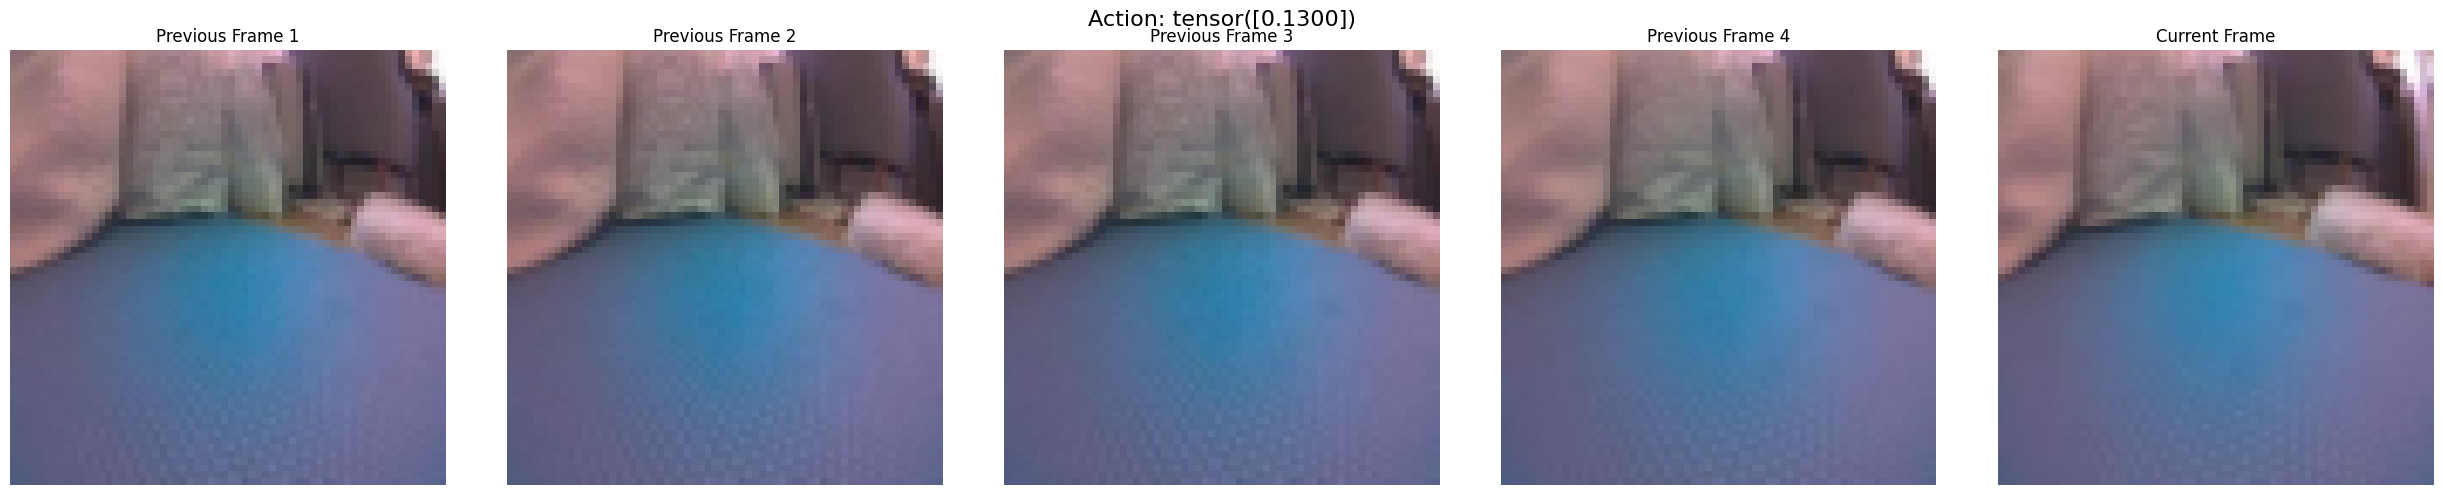

In [12]:
#display_dataset_entry(train_debug_set[25])